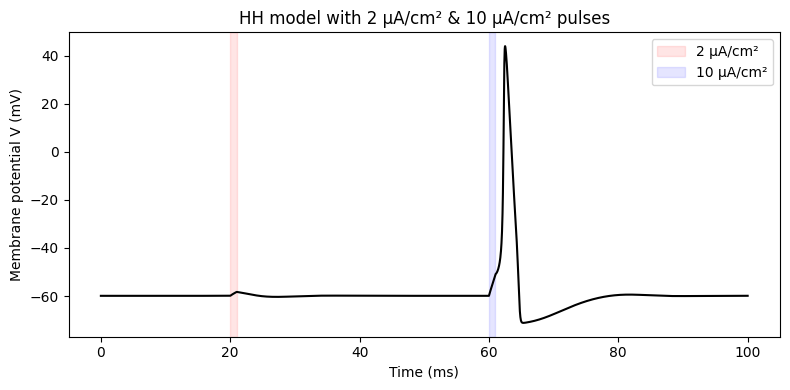

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ---- 1) Model parameters ----
C       = 1.0    # μF/cm²
gbar_K  = 36.0   # mS/cm²
gbar_Na = 120.0  # mS/cm²
g_leak  = 0.3    # mS/cm²
E_K     = -72.0  # mV
E_Na    = 55.0   # mV
E_leak  = -49.0  # mV

# ---- 2) Rate constants α and β ----
def alpha_n(V):
    return 0.01*(V + 50.0) / (1.0 - np.exp(-(V + 50.0)/10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 60.0)/80.0)

def alpha_m(V):
    return 0.1*(V + 35.0) / (1.0 - np.exp(-(V + 35.0)/10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 60.0)/18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 60.0)/20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 30.0)/10.0))

# ---- 3) Steady-states and time-constants from α+β ----
def n_inf(V):
    an = alpha_n(V); bn = beta_n(V)
    return an / (an + bn)

def tau_n(V):
    an = alpha_n(V); bn = beta_n(V)
    return 1.0 / (an + bn)

def m_inf(V):
    am = alpha_m(V); bm = beta_m(V)
    return am / (am + bm)

def tau_m(V):
    am = alpha_m(V); bm = beta_m(V)
    return 1.0 / (am + bm)

def h_inf(V):
    ah = alpha_h(V); bh = beta_h(V)
    return ah / (ah + bh)

def tau_h(V):
    ah = alpha_h(V); bh = beta_h(V)
    return 1.0 / (ah + bh)

# ---- 4) Stimulus current I_app(t) ----
def I_app(t):
    if   t < 20.0:        return 0.0
    elif t < 21.0:        return 2.0
    elif t < 60.0:        return 0.0
    elif t < 61.0:        return 10.0
    else:                 return 0.0

# ---- 5) The HH ODE system ----
# State vector y = [ V, n, m, h ]
def hh_rhs(y, t):
    V, n, m, h = y
    I = I_app(t)

    # gating derivatives in the m∞–τ form
    dn = (n_inf(V) - n) / tau_n(V)
    dm = (m_inf(V) - m) / tau_m(V)
    dh = (h_inf(V) - h) / tau_h(V)

    # conductances
    gK  = gbar_K  * n**4
    gNa = gbar_Na * m**3 * h
    Ileak = g_leak * (V - E_leak)

    # currents (note sign: I_K = gK*(V - E_K), etc.)
    IK  = gK  * (V - E_K)
    INa = gNa * (V - E_Na)

    # membrane equation
    dV = ( I - IK - INa - Ileak ) / C

    return [dV, dn, dm, dh]

# ---- 6) Integrate and plot ----
t   = np.linspace(0, 100.0, 5001)     # 0…100 ms
y0  = [-59.8977, 0.3192, 0.0530, 0.5925]  # [V0, n0, m0, h0]

sol = odeint(hh_rhs, y0, t)
V   = sol[:,0]

plt.figure(figsize=(8,4))
plt.plot(t, V, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential V (mV)')
plt.title('HH model with 2 μA/cm² & 10 μA/cm² pulses')
plt.axvspan(20,21, color='red',   alpha=0.1, label='2 μA/cm²')
plt.axvspan(60,61, color='blue',  alpha=0.1, label='10 μA/cm²')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
